In [2]:
import torch
from torch import nn
import torchvision
from torchview import draw_graph


In [3]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

In [64]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, identity_downsample=None, debug=False):
        super().__init__()
        self.debug = debug
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.identity_downsample = identity_downsample
        self.relu = nn.ReLU()
        mid_out_channels = out_channels // 4

        self.conv1 = nn.Conv2d(in_channels, mid_out_channels, (1,1), stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(mid_out_channels)
        self.conv2 = nn.Conv2d(mid_out_channels, mid_out_channels, (3,3), stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(mid_out_channels)
        self.conv3 = nn.Conv2d(mid_out_channels, out_channels, (1,1), stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        print(f"Identity shape before downsample {identity.shape}") if self.debug else None
        if self.identity_downsample != None:
            identity = self.identity_downsample(identity)
        print(f"Identity shape after downsample {identity.shape}") if self.debug else None
        print(f"X shape Before Adding {x.shape}") if self.debug else None
        x += identity
        x = self.relu(x)
        return x

In [92]:
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, (7,7), stride=2, padding=3),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d((3,3), stride=2, padding=1))
        
        conv2_ddwnsample = nn.Sequential(nn.Conv2d(64, 256, (1,1), stride=1, padding=0), nn.BatchNorm2d(256))
        self.conv2 = nn.Sequential(ResBlock(64, 256, stride=1, identity_downsample=conv2_ddwnsample),
                                   ResBlock(256, 256),
                                   ResBlock(256, 256))
        
        conv3_downsample = nn.Sequential(nn.Conv2d(256, 512, (1,1), stride=2, padding=0), nn.BatchNorm2d(512))
        self.conv3 = nn.Sequential(ResBlock(256, 512, stride=2, identity_downsample=conv3_downsample),
                                   ResBlock(512, 512),
                                   ResBlock(512, 512),
                                   ResBlock(512, 512))
        
        conv4_downsample = nn.Sequential(nn.Conv2d(512, 1024, (1,1), stride=2, padding=0), nn.BatchNorm2d(1024))
        self.conv4 = nn.Sequential(ResBlock(512, 1024, stride=2, identity_downsample=conv4_downsample),
                                   ResBlock(1024, 1024),
                                   ResBlock(1024, 1024),
                                   ResBlock(1024, 1024),
                                   ResBlock(1024, 1024),
                                   ResBlock(1024, 1024))

        conv5_ddwnsample = nn.Sequential(nn.Conv2d(1024, 2048, (1,1), stride=2, padding=0), nn.BatchNorm2d(2048))
        self.conv5 = nn.Sequential(ResBlock(1024, 2048, stride=2, identity_downsample=conv5_ddwnsample),
                                   ResBlock(2048, 2048),
                                   ResBlock(2048, 2048))

        self.avgpool = nn.
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        return x


In [96]:
xx = torch.randn((1,3,224,224))

resnet50 = ResNet(3, 10)
resnet50(xx).shape

torch.Size([1, 2048, 7, 7])

In [98]:
torch.onnx.export(resnet50, xx, "C:/Users/abdoa/Desktop/model.onnx", input_names=['images'], output_names=['classes'])


(process:4916): Pango-WARNING **: 22:30:05.462: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


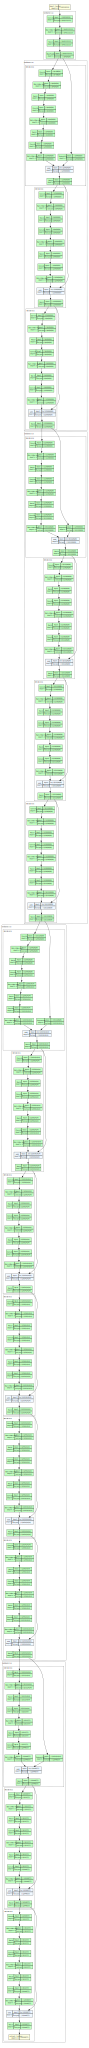

In [94]:
model_graph = draw_graph(ResNet(3, 10), input_size=(1,3,224,224), expand_nested=True)
model_graph.visual_graph